In [192]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import umap
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd

import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingCAC

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import MultiHeadIDEC,  target_distribution
from utils import *

# Utils.py

In [193]:
## Utils.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import linear_sum_assignment as linear_assignment
from read_patients import get_aki
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score, f1_score, roc_auc_score, accuracy_score

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

DATASETS = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"
def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def load_mnist(path='./data/mnist.npz'):
    f = np.load(path)

    x_train, y_train, x_test, y_test = f['x_train'], f['y_train'], f[
        'x_test'], f['y_test']
    f.close()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test)).astype(np.int32)
    x = x.reshape((x.shape[0], -1)).astype(np.float32)
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)
    return x, y


class MnistDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_mnist()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


def is_non_zero_file(fpath):
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0


class parameters(object):
    def __init__(self, parser):
        self.input_dim = -1
        self.dataset = parser.dataset
        
        # Training parameters
        self.lr = parser.lr
        self.alpha = float(parser.alpha)
        self.wd = parser.wd
        self.batch_size = parser.batch_size
        self.n_epochs = parser.n_epochs
        self.pre_epoch = parser.pre_epoch
        self.pretrain = parser.pretrain
        self.load_ae = parser.load_ae
        self.classifier = parser.classifier
        self.tol = parser.tol

        # Model parameters
        self.lamda = parser.lamda
        self.beta = parser.beta
        self.gamma = parser.gamma
        self.delta = parser.delta
        self.hidden_dims = parser.hidden_dims
        self.latent_dim = self.n_z = parser.n_z
        self.n_clusters = parser.n_clusters
        self.clustering = parser.clustering
        self.n_classes = parser.n_classes

        # Utility parameters
        self.device = parser.device
        self.log_interval = parser.log_interval
        self.pretrain_path = parser.pretrain_path + "/" + self.dataset + ".pth"


#######################################################
# Evaluate Critiron
#######################################################


def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.data.cpu().numpy()
    y_pred = y_pred.data.cpu().numpy()

    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row, col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row, col)]) * 1.0 / y_pred.size


def plot(model, X_train, y_train, X_test=None, y_test=None, device="cpu"):
    reducer = umap.UMAP(random_state=42)
    idx = torch.Tensor(np.random.randint(0,len(X_train),\
                        int(0.05*len(X_train)))).type(torch.LongTensor).to(device)
    qs, latents_X = model(X_train[idx], output="latent")
    y_train = y_train[idx]
    q_train = qs
    cluster_id_train = torch.argmax(q_train, axis=1)
    X2 = reducer.fit_transform(latents_X.cpu().detach().numpy())

    print("Training data")

    c_clusters = [color[int(cluster_id_train[i])] for i in range(len(cluster_id_train))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id_train))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()
    if X_test is not None:
        qs, latents_test = model(X_test, output="latent")
        q_test = qs[0]
        X2 = reducer.transform(latents_test.cpu().detach().numpy())
        cluster_id_test = torch.argmax(q_test, axis=1)
        c_clusters = [color[int(cluster_id_test[i])] for i in range(len(cluster_id_test))]
        c_labels = [color[int(y_test[i])] for i in range(len(cluster_id_test))]

        print("Test data")
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()
        columns = cols

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv")
        columns = X_train.columns
        X_train = X_train.to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()
    
    elif DATASET == "kidney":
        print("Fetching Kidney Dataset")
        data = get_aki(base_dir)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv")
        columns = X.columns
        X = X.to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y, columns


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    columns = ["feature_"+str(i) for i in range(n_features)]
    return X, np.array(Y).astype('int'), columns


def get_train_val_test_loaders(args):
    if args.dataset in DATASETS:
        base_dir = "/Users/shivin/Document/NUS/Research/Data"
        # base_dir = "/home/shivin/CAC_code/data"
        print("Loading Dataset:", args.dataset)
        if args.dataset != "kidney":
            if args.dataset == "synthetic":
                n_feat = 45
                X, y, columns = create_imbalanced_data_clusters(n_samples=5000,\
                       n_clusters=args.n_clusters, n_features = n_feat,\
                       inner_class_sep=0.2, outer_class_sep=2, seed=0)
                args.input_dim = n_feat

            elif args.dataset == "paper_synthetic":
                n_feat = 100
                X, y = paper_synthetic(2500, centers=4)
                args.input_dim = n_feat
                print(args.input_dim)

            else:
                X, y, columns = get_dataset(args.dataset, base_dir)
                print(args.dataset)
                args.input_dim = X.shape[1]

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val = sc.fit_transform(X_val)
            X_test = sc.fit_transform(X_test)
            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

        else:
            print("Loading Kidney Train")
            X_train, y_train, columns = get_dataset(args.dataset, base_dir + "/aki/train")
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

            args.input_dim = X_train.shape[1]

            print("Loading Kidney Test")
            X_test, y_test, columns = get_dataset(args.dataset, base_dir + "/aki/test")

            X_train_data_loader = list(zip(X_train.astype(np.float32), y_train, range(len(X_train))))
            X_val_data_loader = list(zip(X_val.astype(np.float32), y_val, range(len(X_val))))
            X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test, range(len(X_train))))

            
        train_loader = torch.utils.data.DataLoader(X_train_data_loader,
            batch_size=args.batch_size, shuffle=True)

        val_loader = torch.utils.data.DataLoader(X_val_data_loader,
            batch_size=args.batch_size, shuffle=True)

        test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
            batch_size=args.batch_size, shuffle=False)

        X_train, y_train = torch.Tensor(X_train).to(args.device), torch.Tensor(y_train).type(torch.LongTensor).to(args.device)
        X_val, y_val = torch.Tensor(X_val).to(args.device), torch.Tensor(y_val).type(torch.LongTensor).to(args.device)
        X_test, y_test = torch.Tensor(X_test).to(args.device), torch.Tensor(y_test).type(torch.LongTensor).to(args.device)

        return columns, (X_train, y_train, train_loader), (X_val, y_val, val_loader), (X_test, y_test, test_loader)
    else:
        return None

    
def paper_synthetic(n_pts=1000, centers=4):
    X, y = make_blobs(n_pts, centers=centers)
    W = np.random.randn(10,2)
    U = np.random.randn(100,10)
    X1 = W.dot(X.T)
    X1 = X1*(X1>0)
    X2 = U.dot(X1)
    X2 = X2*(X2>0)
    return X2.T, y


def nmi_score_torch(y1, y2):
    y1 = y1.data.cpu().numpy()
    y2 = y2.data.cpu().numpy()
    return nmi_score(y1, y2)

def ari_score_torch(y1, y2):
    y1 = y1.data.cpu().numpy()
    y2 = y2.data.cpu().numpy()
    return ari_score(y1, y2)

def f1_score_torch(y1, y2):
    y1 = y1.data.cpu().numpy()
    y2 = y2.data.cpu().numpy()
    return f1_score(y1, y2)

def roc_auc_score_torch(y1, y2):
    y1 = y1.data.cpu().numpy()
    y2 = y2.data.cpu().numpy()
    return roc_auc_score(y1, y2)

def accuracy_score_torch(y1, y2):
    y1 = y1.data.cpu().numpy()
    y2 = y2.data.cpu().numpy()
    return accuracy_score(y1, y2)

In [194]:
import numpy as np
import torch
import os

class EarlyStoppingCAC:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.getcwd() + "/" + path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[0] < self.best_score[0] + self.delta and score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.ae.state_dict(), self.path+".pt")
        for j in range(model.n_clusters):
            torch.save(model.classifiers[j][0].state_dict(), self.path+"_"+str(j)+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.ae.load_state_dict(torch.load(self.path+".pt"))
        for j in range(model.n_clusters):
            model.classifiers[j][0].load_state_dict(torch.load(self.path+"_"+str(j)+".pt"))
        return model

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='./pretrained_model/checkpoint', dataset="", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = [None, None]
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.getcwd() + "/" + path + "_" + dataset
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = val_loss
        if self.best_score[0] is None:
            self.best_score[0] = score[0]
            self.save_checkpoint(val_loss, model)

        if self.best_score[1] is None:
            self.best_score[1] = score[1]
            self.save_checkpoint(val_loss, model)

        if score[0] < self.best_score[0] + self.delta and score[1] < self.best_score[1] + self.delta :
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.classifier.state_dict(), self.path+".pt")
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        print("Loading Best model with score: ", self.best_score)
        model.classifier.load_state_dict(torch.load(self.path+".pt"))
        return model

In [352]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import torch
from utils import is_non_zero_file

class AE(nn.Module):
    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 input_dim, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(input_dim, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, input_dim)

    def forward(self, x, output="decoded"):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)
        if output == "latent":
            return z

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

def source_distribution(z, cluster_layer, alpha=1):
    q = 1.0 / (1.0 + torch.sum(
        torch.pow(z.unsqueeze(1) - cluster_layer, 2), 2) / alpha)
    q = q.pow((alpha + 1.0) / 2.0)
    q = (q.t() / torch.sum(q, 1)).t()
    return q

def pretrain_ae(model, train_loader, args):
    '''
    pretrain autoencoder
    '''
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(50):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(args.device)

            optimizer.zero_grad()
            x_bar, _ = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("Pretraining epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))

class NNClassifier(nn.Module):
    def __init__(self, args, input_dim, ae=None):
        super(NNClassifier, self).__init__()
        self.args = args
        self.n_classes = args.n_classes
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
        self.ae = ae
        self.device = args.device

        if self.ae == None:
            self.input_dim = args.input_dim
        else:
            self.input_dim = args.latent_dim
        if input_dim != None:
            self.input_dim = input_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, args.n_classes),
        ).to(self.device)

        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=args.lr)

    def forward(self, inputs):
        if self.ae == None:
            return self.classifier(inputs)
        else:
            input_z = self.ae(inputs, output="latent")
            return self.classifier(input_z)

    def fit(self, X_batch, y_batch):
        self.optimizer.zero_grad()
        self.classifier.train()
        y_pred = self.forward(X_batch.detach())
        train_loss = self.criterion(y_pred, y_batch)
        train_loss.backward()
        self.optimizer.step()
        return y_pred, train_loss.item()

class MultiHeadIDEC(nn.Module):
    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 args):
        super(MultiHeadIDEC, self).__init__()
        self.alpha = args.alpha
        self.pretrain_path = args.pretrain_path
        self.device = args.device
        self.n_clusters = args.n_clusters
        self.input_dim = args.input_dim
        self.n_z = args.n_z
        self.args = args

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            input_dim=self.input_dim,
            n_z=self.n_z)

        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        self.p_cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        self.n_cluster_layer = Parameter(torch.Tensor(self.n_clusters, self.n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)
        torch.nn.init.xavier_normal_(self.p_cluster_layer.data)
        torch.nn.init.xavier_normal_(self.n_cluster_layer.data)
        
        self.classifiers = []
        for _ in range(self.n_clusters):
            classifier = nn.Sequential(
                nn.Linear(self.n_z, 16),
                nn.ReLU(),
                nn.Linear(16, 8),
                nn.ReLU(),
                nn.Linear(8, args.n_classes),
            ).to(self.device)
            optimizer = torch.optim.Adam(classifier.parameters(), lr=args.lr)
            self.classifiers.append([classifier, optimizer])
            

    def pretrain(self, train_loader, path=''):
        print(path)
        if not is_non_zero_file(path):
            path = ''
        if path == '':
            pretrain_ae(self.ae, train_loader, self.args)
        else:
            # load pretrain weights
            self.ae.load_state_dict(torch.load(self.pretrain_path))
            print('load pretrained ae from', path)

    def predict(self, X_test):
        qs, z_test = self.forward(X_test)
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((self.n_clusters, 2))
        for j in range(self.n_clusters):
            preds[j,:] = self.classifiers[cluster_ids[j]]
        return preds
        
    def forward(self, x, output="default"):
        x_bar, z = self.ae(x)
        # Cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()

        if output == "latent":
            return q, z

        elif output == "classifier":
            preds = torch.zeros((len(z), 2))
            for j in range(len(z)):
                preds[j,:] = self.classifiers[j](z)
            return preds
        
        else:
            return z, x_bar, q

In [353]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 50,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",

# Model parameters
'lamda' : 1,
'beta' : 1, # KL loss/KM loss weight
'gamma' : 1, # Classification loss weight
'delta' : 0.1, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 4,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model'}
# 'pretrain_path': ''}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'paper_synthetic', 'kidney', 'infant', 'wid_mortality']

In [354]:
column_names, train_data, val_data, test_data = get_train_val_test_loaders(args)
os.chdir(BASE_DIR)
X_train, y_train, train_loader = train_data
X_val, y_val, val_loader = val_data
X_test, y_test, test_loader = test_data

Loading Dataset: cic
cic


In [355]:
print(column_names)
args.input_dim = X_train.shape[1]
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/DeepCAC"
os.chdir(BASE_DIR)

Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Gender', 'Height', 'Weight',
       'CCU', 'CSRU', 'SICU',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=117)


In [180]:
# X_train_kidney = X_train
# y_train_kidney = y_train
# X_val_kidney = X_val
# y_val_kidney = y_val
# X_test_kidney = X_test
# y_test_kidney = y_test
X_train = X_train_kidney
y_train = y_train_kidney
X_val = X_val_kidney
y_val = y_val_kidney
X_test = X_test_kidney
y_test = y_test_kidney

# MultiHead IDEC

## Initialization

In [356]:
model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
x_bar, hidden = model.ae(X_train)

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
cluster_indices = torch.Tensor(kmeans.labels_).to(device)
original_cluster_centers = kmeans.cluster_centers_

y_pred_last = y_pred
model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)

## Initialization ##
for i in range(args.n_clusters):
    cluster_idx = torch.where(cluster_indices == i)[0]
    cluster_idx_p = torch.where(y_train[cluster_idx] == 1)[0]
    cluster_idx_n = torch.where(y_train[cluster_idx] == 0)[0]
    hidden_p = hidden[cluster_idx][cluster_idx_p]
    hidden_n = hidden[cluster_idx][cluster_idx_n]
    
    model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
    model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

criterion = nn.CrossEntropyLoss(reduction='mean')


/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/cic.pth


## Clustering Step

Starting Training
Training data


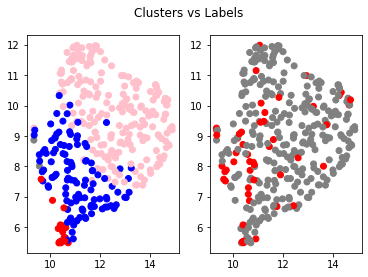


[ 0/50] train_loss: 2.831 val_loss: 0.675 val_F1: 0.252 val_AUC: 0.438 val_NMI: 0.006 val_ACC: 0.197 val_ARI: 0.003 
Epoch: 00 | Loss: 10607.220 | Classification Loss: 2.056 | Class Sep Loss: 7.117
Epoch: 01 | Loss: 3785.711 | Classification Loss: 1.767 | Class Sep Loss: 5.014
Training data


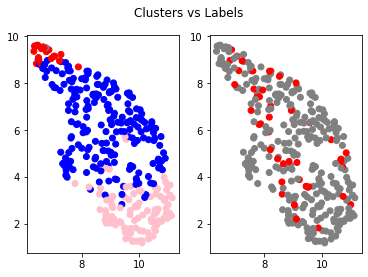


[ 2/50] train_loss: 1.928 val_loss: 0.420 val_F1: 0.000 val_AUC: 0.496 val_NMI: 0.005 val_ACC: 0.208 val_ARI: 0.007 
Epoch: 02 | Loss: 2343.431 | Classification Loss: 1.353 | Class Sep Loss: 6.276
Epoch: 03 | Loss: 1860.719 | Classification Loss: 1.398 | Class Sep Loss: 4.686
Training data


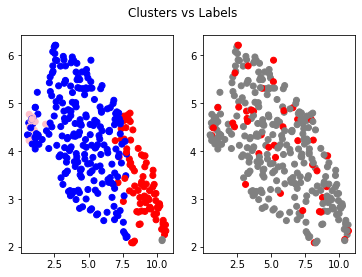


[ 4/50] train_loss: 1.903 val_loss: 0.416 val_F1: 0.000 val_AUC: 0.542 val_NMI: 0.001 val_ACC: 0.184 val_ARI: -0.001 
Epoch: 04 | Loss: 1113.206 | Classification Loss: 1.906 | Class Sep Loss: 2.457
Epoch: 05 | Loss: 888.978 | Classification Loss: 1.005 | Class Sep Loss: 3.915
Training data


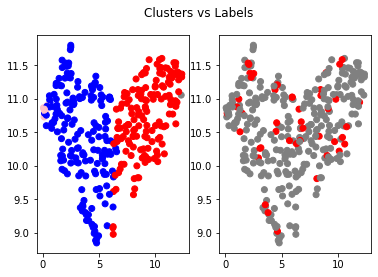


[ 6/50] train_loss: 1.824 val_loss: 0.411 val_F1: 0.000 val_AUC: 0.555 val_NMI: 0.000 val_ACC: 0.194 val_ARI: -0.001 
Epoch: 06 | Loss: 885.454 | Classification Loss: 0.698 | Class Sep Loss: 4.664
Epoch: 07 | Loss: nan | Classification Loss: nan | Class Sep Loss: 1.930
Training data


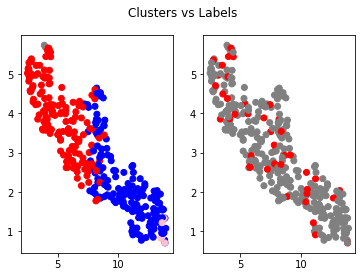


[ 8/50] train_loss: 1.683 val_loss: 0.401 val_F1: 0.000 val_AUC: 0.582 val_NMI: 0.000 val_ACC: 0.194 val_ARI: -0.002 
Epoch: 08 | Loss: 607.205 | Classification Loss: 1.277 | Class Sep Loss: 2.049
Epoch: 09 | Loss: 552.058 | Classification Loss: 1.024 | Class Sep Loss: 2.262
Training data


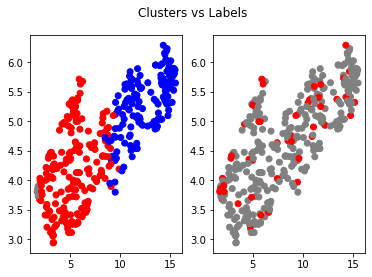


[10/50] train_loss: 1.560 val_loss: 0.387 val_F1: 0.000 val_AUC: 0.642 val_NMI: 0.001 val_ACC: 0.202 val_ARI: 0.002 
Epoch: 10 | Loss: 421.408 | Classification Loss: 0.520 | Class Sep Loss: 1.051
Epoch: 11 | Loss: 355.661 | Classification Loss: 0.675 | Class Sep Loss: 2.795
Training data


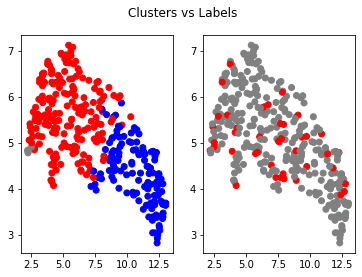


[12/50] train_loss: 1.477 val_loss: 0.371 val_F1: 0.006 val_AUC: 0.718 val_NMI: 0.001 val_ACC: 0.212 val_ARI: 0.006 
Epoch: 12 | Loss: 321.703 | Classification Loss: 0.438 | Class Sep Loss: 1.538
Epoch: 13 | Loss: 335.297 | Classification Loss: 0.487 | Class Sep Loss: 1.620
Training data


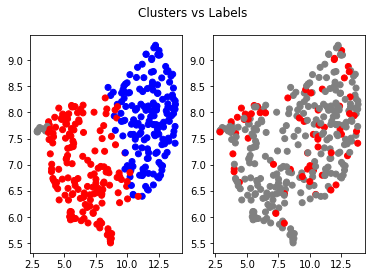

ValueError: n_samples=1 should be >= n_clusters=2.

In [357]:
print("Starting Training")
model.train()
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

N_EPOCHS = args.n_epochs
es = EarlyStoppingCAC(dataset = args.dataset)
kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
val_cluster_labels = torch.Tensor(kmeans.fit_predict(X_val.data.cpu().numpy())).to(device)
test_cluster_labels = torch.Tensor(kmeans.fit_predict(X_test.data.cpu().numpy())).to(device)

kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

for epoch in range(N_EPOCHS):
    if epoch % args.log_interval == 0:
        plot(model, torch.FloatTensor(X_train).to(args.device), y_train)
        X_latents, _, tmp_q = model(X_train, output="decoded")
        # update target distribution p
        tmp_q = tmp_q.data

        p = target_distribution(tmp_q)

        # evaluate clustering performance
        y_pred = tmp_q.cpu().numpy().argmax(1)
        delta_label = np.sum(y_pred != y_pred_last).astype(
            np.float32) / y_pred.shape[0]
        y_pred_last = y_pred
        cluster_indices = torch.argmax(tmp_q, axis=1)

        # Calculate Training Metrics
        train_loss = 0
        for j in range(args.n_clusters):
            cluster_idx = torch.where(cluster_indices == j)[0]
            X_cluster = X_latents[cluster_idx]
            y_cluster = y_train[cluster_idx]

            classifier_k, optimizer_k = model.classifiers[j]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            train_loss += cluster_los

        model.ae.eval() # prep model for evaluation
        for j in range(model.n_clusters):
            model.classifiers[j][0].eval()

        # Evaluate model on Validation dataset
        qs, z_val = model(X_val, output="latent")
        q_val = qs
        cluster_ids = torch.argmax(q_val, axis=1)
        preds = torch.zeros((len(z_val), 2)).to(args.device)

        # Weighted predictions
        nmi, acc, ari = 0, 0, 0
        if args.attention == False:
            for j in range(model.n_clusters):
                cluster_id = torch.where(cluster_ids == j)[0]
                X_cluster = z_val[cluster_id]
                cluster_preds_val = model.classifiers[j][0](X_cluster)
                preds[cluster_id,:] = cluster_preds_val

                y_pred_idx = torch.Tensor(kmeans.fit_predict(X_cluster.data.cpu().numpy())).to(args.device)
                nmi_k = nmi_score_torch(y_pred_idx, y_val[cluster_id])
                nmi += nmi_k * len(cluster_id)/len(X_train)
                acc += cluster_acc(y_pred_idx, y_val[cluster_id]) * len(cluster_id)/len(X_train)
                ari += ari_score_torch(y_pred_idx, y_val[cluster_id]) * len(cluster_id)/len(X_train)

        else:
            for j in range(model.n_clusters):
                cluster_id = torch.where(cluster_ids == j)[0]
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                preds[:,0] += q_val[:,j]*cluster_preds[:,0]
                preds[:,1] += q_val[:,j]*cluster_preds[:,1]

                y_pred_idx = torch.Tensor(kmeans.fit_predict(X_cluster[cluster_id].data.cpu().numpy())).to(args.device)
                nmi_k = nmi_score_torch(y_pred_idx, y_val[cluster_id])
                nmi += nmi_k * len(cluster_id)/len(X_train)
                acc += cluster_acc(y_pred_idx, y_val[cluster_id]) * len(cluster_id)/len(X_train)
                ari += ari_score_torch(y_pred_idx, y_val[cluster_id]) * len(cluster_id)/len(X_train)

        # nmi = nmi_score_torch(val_cluster_labels, kmeans.fit_predict(X_cluster.data.cpu().numpy()))
        val_f1  = f1_score_torch(y_val, torch.argmax(preds, axis=1))
        val_auc = roc_auc_score_torch(y_val, preds[:,1])

        loss = criterion(preds, y_val)
        # record validation loss
        valid_losses.append(loss.item())

        # calculate average loss over an epoch
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(N_EPOCHS))
        
        print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.3f} ' +
                     f'val_loss: {valid_loss:.3f} '  +
                     f'val_F1: {val_f1:.3f} '  +
                     f'val_AUC: {val_auc:.3f} ' +
                     f'val_NMI: {nmi:.3f} '  +
                     f'val_ACC: {acc:.3f} '  +
                     f'val_ARI: {ari:.3f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        es([val_f1, val_auc], model)
        if es.early_stop == True:
            break

    # Normal Training
    epoch_loss = 0
    epoch_sep_loss = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        # torch.autograd.set_detect_anomaly(True)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, q = model(x_batch)
        reconstr_loss = F.mse_loss(x_bar, x_batch)

        classifier_labels = np.zeros(len(idx))

        if args.attention == False:
            classifier_labels = torch.argmax(q, axis=1)

        train_epochs = min(10, 1 + int(epoch/5))
        for _ in range(train_epochs):
            if args.attention == True:
                # Choose classifier for a point probabilistically
                for j in range(len(idx)):
                    classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q[j].data.cpu().numpy())
                
                classifier_labels = torch.Tensor(classifier_labels)

            for k in range(args.n_clusters):
                idx_cluster = torch.where(classifier_labels == k)[0].to(args.device)
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = criterion(y_pred_cluster, y_cluster)
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = torch.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            class_loss += cluster_los

        N1 = sum(y_batch).item()
        N0 = len(y_batch) - N1

        p_idx = torch.where(y_batch == 1)[0]
        n_idx = torch.where(y_batch == 0)[0]
        
        delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        cluster_id = torch.argmax(q, 1)
        
        positive_class_dist = 0
        negative_class_dist = 0
        km_loss             = 0
        class_sep_loss = 0

        for j in range(args.n_clusters):
            pts_index = torch.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            n_class_index = torch.where(y_batch[pts_index] == 0)[0]
            p_class_index = torch.where(y_batch[pts_index] == 1)[0]

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])

            class_sep_loss += (s1+s2)/m12
            km_loss += torch.square(torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j]))/(1+len(cluster_pts))

        loss = reconstr_loss
        if args.beta != 0:
            loss += args.beta*km_loss
        if args.gamma != 0:
            loss += args.gamma*class_loss
        if args.delta != 0:
            loss += args.delta*class_sep_loss

        epoch_loss += loss
        epoch_sep_loss += class_sep_loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = torch.where(cluster_id == j)[0]
            n_class_index = torch.where(y_batch[pts_index] == 0)[0]
            p_class_index = torch.where(y_batch[pts_index] == 1)[0]

            N  = len(pts_index)
            Np = len(p_class_index)
            Nn = len(n_class_index)
            model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | Classification Loss: {:.3f} | Class Sep Loss: {:.3f}'.format(
                epoch, epoch_loss, class_loss/train_epochs, class_sep_loss))


plot(model, X_train, y_train)

## Local Training

In [358]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset = args.dataset, delta=0.001)

qs, latents_X = model(X_train, output="latent")
q_train = qs
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(latents_X.to(args.device), q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

# Post clustering training
for epoch in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        for j in range(len(X_latents)):
            classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].data.cpu().numpy())

        classifier_labels = torch.Tensor(classifier_labels).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = torch.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = criterion(y_pred_cluster, y_cluster)
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()
    
    model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    # Evaluate model on Validation set
    qs, z_val = model(X_val, output="latent")
    q_val = qs
    cluster_ids = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2)).to(args.device)

    if args.attention == False:
        # Hard local predictions
        for j in range(model.n_clusters):
            cluster_id = torch.where(cluster_ids == j)[0]
            X_cluster = z_val[cluster_id]
            cluster_preds_val = model.classifiers[j][0](X_cluster)
            preds[cluster_id,:] = cluster_preds_val

    else:
        # Weighted predictions
        for j in range(model.n_clusters):
            # Classification Evaluation Metrics
            cluster_id = torch.where(cluster_ids == j)[0]
            X_cluster = z_val
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[:,0] += q_val[:,j]*cluster_preds[:,0]
            preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score_torch(y_val, torch.argmax(preds, axis=1))
    val_auc = roc_auc_score_torch(y_val, preds[:,1])

    loss = criterion(preds, y_val)
    # record validation loss
    valid_losses.append(loss.item())

    # calculate average loss over an epoch
    valid_loss = np.average(valid_losses)
    avg_valid_losses.append(valid_loss)
    
    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'val_loss: {valid_loss:.3f} '  +
                 f'val_F1: {val_f1:.3f} '  +
                 f'val_AUC: {val_auc:.3f} ')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        break


####################################################################################

Training Local Networks
Loading Best model with score:  [0.006134969325153375, 0.7182105894105895]

[ 0/50] train_loss: 1.411 val_loss: 0.372 val_F1: 0.006 val_AUC: 0.718 
EarlyStopping counter: 1 out of 5

[ 1/50] train_loss: 1.411 val_loss: 0.371 val_F1: 0.000 val_AUC: 0.719 
EarlyStopping counter: 2 out of 5

[ 2/50] train_loss: 1.411 val_loss: 0.370 val_F1: 0.000 val_AUC: 0.718 
EarlyStopping counter: 3 out of 5

[ 3/50] train_loss: 1.411 val_loss: 0.370 val_F1: 0.006 val_AUC: 0.722 

[ 4/50] train_loss: 1.411 val_loss: 0.369 val_F1: 0.006 val_AUC: 0.726 

[ 5/50] train_loss: 1.411 val_loss: 0.368 val_F1: 0.006 val_AUC: 0.728 

[ 6/50] train_loss: 1.411 val_loss: 0.367 val_F1: 0.012 val_AUC: 0.730 

[ 7/50] train_loss: 1.411 val_loss: 0.367 val_F1: 0.012 val_AUC: 0.730 
EarlyStopping counter: 1 out of 5

[ 8/50] train_loss: 1.411 val_loss: 0.366 val_F1: 0.012 val_AUC: 0.731 

[ 9/50] train_loss: 

## Evaluating on Test Data

In [359]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# Evaluate model on Test dataset
qs, z_test = model(X_test, output="latent")
q_test = qs
cluster_ids = torch.argmax(q_test, axis=1)
preds_test = torch.zeros((len(z_test), 2)).to(args.device)

# Weighted predictions
nmi, acc, ari = 0, 0, 0
for j in range(model.n_clusters):
    # Classification Evaluation Metrics
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_preds_test = model.classifiers[j][0](X_cluster)
    preds_test[:,0] += q_test[:,j]*cluster_preds_test[:,0]
    preds_test[:,1] += q_test[:,j]*cluster_preds_test[:,1]

    # Clustering Evaluation Metrics
    y_pred_idx = torch.Tensor(kmeans.fit_predict(X_cluster[cluster_id].data.cpu().numpy())).to(args.device)
    nmi_k = nmi_score_torch(y_pred_idx, y_test[cluster_id])
    nmi += nmi_k * len(cluster_id)/len(X_train)
    acc += cluster_acc(y_pred_idx, y_test[cluster_id]) * len(cluster_id)/len(X_train)
    ari += ari_score_torch(y_pred_idx, y_test[cluster_id]) * len(cluster_id)/len(X_train)

# nmi = nmi_score_torch(test_cluster_labels, kmeans.fit_predict(X_cluster.data.cpu().numpy()))

e_test_f1 = f1_score_torch(y_test, torch.argmax(preds_test, axis=1))
e_test_auc = roc_auc_score_torch(y_test, preds_test[:,1])
e_test_acc = accuracy_score_torch(y_test, torch.argmax(preds_test, axis=1))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    cluster_preds_test = model.classifiers[j][0](X_cluster)
    preds_test[cluster_id,:] = cluster_preds_test

test_f1 = f1_score_torch(y_test, torch.argmax(preds_test, axis=1))
test_auc = roc_auc_score_torch(y_test, preds_test[:,1])
test_acc = accuracy_score_torch(y_test, torch.argmax(preds_test, axis=1))

print('Acc {:.4f}'.format(acc),
      ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))

# print(test_f1, test_auc)
print('Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))



####################################################################################

Evaluating Test Data with k =  4  Attention =  True
Loading Best model with score:  [0.0243161094224924, 0.7478073926073926]


ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required.

In [156]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################


regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_test[cluster_id].data.cpu().numpy()
    y_cluster = preds_test[cluster_id].data.cpu().numpy()[:,1]
    regs[j].fit(X_cluster, y_cluster)
    best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
    print("Cluster # ", j)
    print(column_names[best_features])
    print("=========================\n")

Cluster #  0
Index(['0', '4', '12', '7', '5', '11', '8', '10', '6', '2'], dtype='object')

Cluster #  1
Index(['0', '7', '12', '4', '5', '10', '8', '13', '11', '1'], dtype='object')

Cluster #  2
Index(['10', '4', '11', '7', '0', '12', '5', '2', '3', '6'], dtype='object')



## Baseline Model

In [22]:
m = NNClassifier(args, input_dim=args.input_dim)
device = args.device

N_EPOCHS = args.n_epochs
es = EarlyStopping(dataset=args.dataset, path="./pretrained_model/checkpoint_base")

kmeans = KMeans(n_clusters=args.n_classes, n_init=20)

for e in range(1, N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    m.train()
    nmi, acc, ari = 0, 0, 0

    for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score_torch(torch.argmax(y_pred, axis=1), y_batch)
        acc = roc_auc_score_torch(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()


    m.classifier.eval()
    val_pred = m(X_val)
    val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, y_val)

    val_f1 = f1_score_torch(torch.argmax(val_pred, axis=1), y_val)
    val_auc = roc_auc_score_torch(y_val, val_pred[:,1])
    es([val_f1, val_auc], m)

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
        f'Val F1: {val_f1:.3f} | Val Acc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

    if es.early_stop == True:
        break


###################################### Testing #####################################

print("\n####################################################################################\n")
print("Evaluating Test Data")

# Load best model trained from local training phase
m = es.load_checkpoint(m)
m.classifier.eval()
test_pred = m.classifier(X_test)
test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, y_test)

test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
test_auc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())

print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
    f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| ',
    f'Test F1: {test_f1:.3f} | Test Acc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')


reg = GradientBoostingRegressor(random_state=0)

reg.fit(X_test, y_test)
best_features = np.argsort(reg.feature_importances_)[::-1][:10]
print("Best Features ")
print(column_names[best_features])
print("=========================\n")

Epoch 001: | Train Loss: 0.71193 |  Train F1: 0.000 | Train Acc: 0.482|  Val F1: 0.000 | Val Acc: 0.498 | Val Loss: 0.699
Epoch 002: | Train Loss: 0.69308 |  Train F1: 0.346 | Train Acc: 0.528|  Val F1: 0.669 | Val Acc: 0.543 | Val Loss: 0.692
Epoch 003: | Train Loss: 0.68910 |  Train F1: 0.681 | Train Acc: 0.515|  Val F1: 0.676 | Val Acc: 0.518 | Val Loss: 0.688
Epoch 004: | Train Loss: 0.68484 |  Train F1: 0.685 | Train Acc: 0.572|  Val F1: 0.672 | Val Acc: 0.625 | Val Loss: 0.684
Epoch 005: | Train Loss: 0.67845 |  Train F1: 0.660 | Train Acc: 0.652|  Val F1: 0.626 | Val Acc: 0.654 | Val Loss: 0.675
Epoch 006: | Train Loss: 0.66846 |  Train F1: 0.632 | Train Acc: 0.662|  Val F1: 0.604 | Val Acc: 0.661 | Val Loss: 0.662
Epoch 007: | Train Loss: 0.65586 |  Train F1: 0.616 | Train Acc: 0.667|  Val F1: 0.643 | Val Acc: 0.668 | Val Loss: 0.655
Epoch 008: | Train Loss: 0.64956 |  Train F1: 0.612 | Train Acc: 0.674|  Val F1: 0.592 | Val Acc: 0.676 | Val Loss: 0.648
Epoch 009: | Train Loss:

# OLD CODE

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/creditcard.pth
Load pretrained AE from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/DeepCAC/pretrained_model/creditcard.pth
NMI score=0.0144
Starting Training
Training data


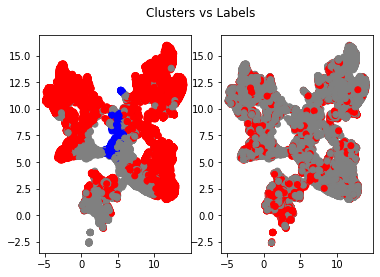

0.3528356870656803 0.5718300570057607
0.3174642635177129 0.5627465390552949
Iter 0 : Acc 0.5541 , nmi 0.0144 , ari -0.0031 , Test F1 0.317, Test AUC 0.563
Epoch: 00 | Loss: 86.883 | Classification Loss: 1.403 | Class Sep Loss: 1.829
Epoch: 01 | Loss: 67.760 | Classification Loss: 1.397 | Class Sep Loss: 0.908
Epoch: 02 | Loss: 64.346 | Classification Loss: 1.431 | Class Sep Loss: 0.796
Epoch: 03 | Loss: 63.044 | Classification Loss: 1.424 | Class Sep Loss: 0.867
Epoch: 04 | Loss: 63.025 | Classification Loss: 1.219 | Class Sep Loss: 1.132
Epoch: 05 | Loss: 64.007 | Classification Loss: 0.603 | Class Sep Loss: 1.053
Epoch: 06 | Loss: 63.102 | Classification Loss: 0.726 | Class Sep Loss: 0.510
Epoch: 07 | Loss: 62.925 | Classification Loss: 0.597 | Class Sep Loss: 1.149
Epoch: 08 | Loss: 62.424 | Classification Loss: 0.674 | Class Sep Loss: 1.119
Epoch: 09 | Loss: 61.893 | Classification Loss: 0.702 | Class Sep Loss: 1.077
Training data


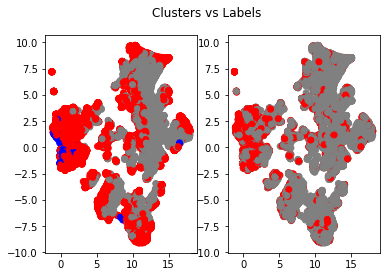

0.48611111111111116 0.7842938332030154
0.4962406015037594 0.7801297144198511
Iter 10 : Acc 0.6070 , nmi 0.0846 , ari 0.0759 , Test F1 0.496, Test AUC 0.780
Epoch: 10 | Loss: 61.731 | Classification Loss: 0.442 | Class Sep Loss: 1.003
Epoch: 11 | Loss: 61.393 | Classification Loss: 0.434 | Class Sep Loss: 1.032
Epoch: 12 | Loss: 60.926 | Classification Loss: 0.450 | Class Sep Loss: 1.088
Epoch: 13 | Loss: 60.560 | Classification Loss: 0.452 | Class Sep Loss: 0.947
Epoch: 14 | Loss: 60.176 | Classification Loss: 0.426 | Class Sep Loss: 1.028
Epoch: 15 | Loss: 60.249 | Classification Loss: 0.313 | Class Sep Loss: 0.965
Epoch: 16 | Loss: 60.062 | Classification Loss: 0.332 | Class Sep Loss: 0.884
Epoch: 17 | Loss: 59.510 | Classification Loss: 0.334 | Class Sep Loss: 0.891
Epoch: 18 | Loss: 59.336 | Classification Loss: 0.321 | Class Sep Loss: 0.934
Epoch: 19 | Loss: 59.365 | Classification Loss: 0.330 | Class Sep Loss: 0.801
Training data


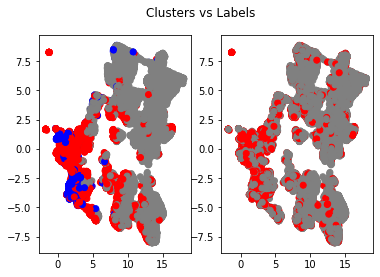

0.5060407317915084 0.7765177240800887
0.5109739368998628 0.7716670864409159
Iter 20 : Acc 0.6846 , nmi 0.1078 , ari 0.1292 , Test F1 0.511, Test AUC 0.772
Epoch: 20 | Loss: 58.769 | Classification Loss: 0.245 | Class Sep Loss: 0.881
Epoch: 21 | Loss: 58.760 | Classification Loss: 0.238 | Class Sep Loss: 0.870
Epoch: 22 | Loss: 58.578 | Classification Loss: 0.245 | Class Sep Loss: 0.912
Epoch: 23 | Loss: 58.217 | Classification Loss: 0.267 | Class Sep Loss: 0.836
Epoch: 24 | Loss: 58.096 | Classification Loss: 0.260 | Class Sep Loss: 0.844
Epoch: 25 | Loss: 57.937 | Classification Loss: 0.223 | Class Sep Loss: 0.820
Epoch: 26 | Loss: 57.606 | Classification Loss: 0.173 | Class Sep Loss: 0.790
Epoch: 27 | Loss: 57.726 | Classification Loss: 0.209 | Class Sep Loss: 0.688
Epoch: 28 | Loss: 57.459 | Classification Loss: 0.193 | Class Sep Loss: 0.696
Epoch: 29 | Loss: 57.042 | Classification Loss: 0.237 | Class Sep Loss: 0.729
Training data


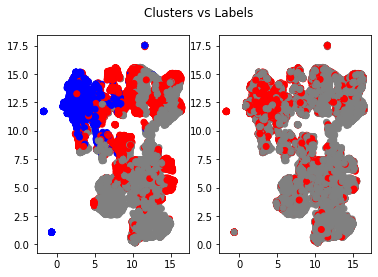

0.49387897866386854 0.7753152588148414
0.4889045438534695 0.7677920062452384
Iter 30 : Acc 0.6575 , nmi 0.1125 , ari 0.1136 , Test F1 0.489, Test AUC 0.768
Epoch: 30 | Loss: 56.764 | Classification Loss: 0.176 | Class Sep Loss: 0.676
Epoch: 31 | Loss: 56.785 | Classification Loss: 0.182 | Class Sep Loss: 0.681
Epoch: 32 | Loss: 56.432 | Classification Loss: 0.177 | Class Sep Loss: 0.663
Epoch: 33 | Loss: 56.374 | Classification Loss: 0.178 | Class Sep Loss: 0.708
Epoch: 34 | Loss: 56.477 | Classification Loss: 0.172 | Class Sep Loss: 0.701
Epoch: 35 | Loss: 55.956 | Classification Loss: 0.162 | Class Sep Loss: 0.651
Epoch: 36 | Loss: 55.522 | Classification Loss: 0.134 | Class Sep Loss: 0.655
Epoch: 37 | Loss: 55.163 | Classification Loss: 0.154 | Class Sep Loss: 0.647
Epoch: 38 | Loss: 55.218 | Classification Loss: 0.148 | Class Sep Loss: 0.658
Epoch: 39 | Loss: 54.763 | Classification Loss: 0.145 | Class Sep Loss: 0.656
Training data


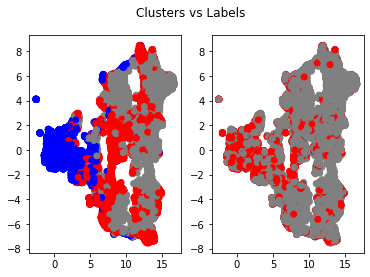

0.4161896974652494 0.7640339302899074
0.4108463434675432 0.7594359925718753
Iter 40 : Acc 0.6542 , nmi 0.1232 , ari 0.1100 , Test F1 0.411, Test AUC 0.759
Epoch: 40 | Loss: 55.021 | Classification Loss: 0.136 | Class Sep Loss: 0.690
Epoch: 41 | Loss: 54.765 | Classification Loss: 0.130 | Class Sep Loss: 0.654
Epoch: 42 | Loss: 54.515 | Classification Loss: 0.126 | Class Sep Loss: 0.686
Epoch: 43 | Loss: 53.969 | Classification Loss: 0.132 | Class Sep Loss: 0.644
Epoch: 44 | Loss: 54.259 | Classification Loss: 0.122 | Class Sep Loss: 0.645
Epoch: 45 | Loss: 53.637 | Classification Loss: 0.117 | Class Sep Loss: 0.647
Epoch: 46 | Loss: 53.927 | Classification Loss: 0.116 | Class Sep Loss: 0.640
Epoch: 47 | Loss: 53.604 | Classification Loss: 0.120 | Class Sep Loss: 0.665
Epoch: 48 | Loss: 53.263 | Classification Loss: 0.120 | Class Sep Loss: 0.646
Epoch: 49 | Loss: 53.202 | Classification Loss: 0.110 | Class Sep Loss: 0.701


In [61]:

model = MultiHeadIDEC(
        n_enc_1=128,
        n_enc_2=64,
        n_enc_3=32,
        n_dec_1=32,
        n_dec_2=64,
        n_dec_3=128,
        args=args).to(args.device)

model.pretrain(train_loader, args.pretrain_path)

optimizer = Adam(model.parameters(), lr=args.lr)

# cluster parameter initiate
device = args.device
y = y_train
x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
cluster_indices = kmeans.labels_

nmi = 0
for j in range(args.n_clusters):
    kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
    cluster_idx = np.where(cluster_indices == j)[0]
    y_pred_idx = kmeans.fit_predict(hidden.data.cpu().numpy()[cluster_idx])
    nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
    nmi += len(cluster_idx)*nmi_k

print("NMI score={:.4f}".format(nmi/len(X_train)))

y_pred_last = y_pred

kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
cluster_indices = kmeans.labels_

model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)
for i in range(args.n_clusters):
    cluster_idx = np.where(cluster_indices == i)[0]
    cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
    cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
    hidden_p = hidden[cluster_idx][cluster_idx_p]
    hidden_n = hidden[cluster_idx][cluster_idx_n]
    
    model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
    model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

criterion = nn.CrossEntropyLoss(reduction='mean')


####################################################################################
####################################################################################
####################################################################################
################################## Clustering Step #################################
####################################################################################
####################################################################################
####################################################################################


print("Starting Training")
model.train()
for epoch in range(50):
    if epoch % args.log_interval == 0:
        plot(model, torch.FloatTensor(X_train).to(args.device), y_train)
        X_latents, _, tmp_q = model(torch.Tensor(X_train).to(args.device), output="decoded")
        tmp_q, tmp_q_p, tmp_q_n = tmp_q
        # update target distribution p
        tmp_q = tmp_q.data

        p = target_distribution(tmp_q)
        p_p = target_distribution(tmp_q_p)
        p_n = target_distribution(tmp_q_n)

        # evaluate clustering performance
        y_pred = tmp_q.cpu().numpy().argmax(1)
        delta_label = np.sum(y_pred != y_pred_last).astype(
            np.float32) / y_pred.shape[0]
        y_pred_last = y_pred

        acc = cluster_acc(y, y_pred)
        # nmi = nmi_score(y, y_pred)

        nmi = 0
        acc = 0
        ari = 0
        for j in range(args.n_clusters):
            kmeans = KMeans(n_clusters=args.n_classes, n_init=20)
            cluster_idx = np.where(cluster_indices == j)[0]
            y_pred_idx = kmeans.fit_predict(X_latents.data.cpu().numpy()[cluster_idx])
            nmi_k = nmi_score(y_pred_idx, y[cluster_idx])
            nmi += nmi_k * len(cluster_idx)/len(X_train)
            acc += cluster_acc(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)
            ari += ari_score(y_pred_idx, y[cluster_idx]) * len(cluster_idx)/len(X_train)

        # ari = ari_score(y, y_pred)
        qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        preds = torch.zeros((len(z_test), 2))

        # Weighted predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            # X_cluster = z_test[cluster_id]
            X_cluster = z_test
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[:,0] += q_test[:,j]*cluster_preds[:,0]
            preds[:,1] += q_test[:,j]*cluster_preds[:,1]

        test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
        test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
        print(test_f1, test_auc)
        # Hard local predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            X_cluster = z_test[cluster_id]
            cluster_preds = model.classifiers[j][0](X_cluster)
            preds[cluster_id,:] = cluster_preds

        test_f1 = f1_score(y_test, np.argmax(preds.detach().numpy(), axis=1))
        test_auc = roc_auc_score(y_test, preds[:,1].detach().numpy())
        print(test_f1, test_auc)
        
        print('Iter {}'.format(epoch), ': Acc {:.4f}'.format(acc),
              ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari), 
              ', Test F1 {:.3f}, Test AUC {:.3f}'.format(test_f1, test_auc))

        if epoch > 0 and delta_label < args.tol:
            print('delta_label {:.4f}'.format(delta_label), '< tol',
                  args.tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    epoch_loss = 0
    epoch_sep_loss = 0
    for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
        # torch.autograd.set_detect_anomaly(True)
        x_batch = x_batch.to(device)
        idx = idx.to(device)

        X_latents, x_bar, qs = model(x_batch)

#         print(batch_idx, qs, model.cluster_layer)

        q, q_p, q_n = qs
        reconstr_loss = F.mse_loss(x_bar, x_batch)
        kl_loss = F.kl_div(q.log(), p[idx], reduction="batchmean")
        
        classifier_labels = np.zeros(len(idx))
        train_epochs = min(10, 1 + int(epoch/5))
        for _ in range(train_epochs):
        # Choose classifier for a point probabilistically
            for j in range(len(idx)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q[j].detach().numpy())

            for k in range(args.n_clusters):
                idx_cluster = np.where(classifier_labels == k)[0]
                X_cluster = X_latents[idx_cluster]
                y_cluster = y_batch[idx_cluster]

                classifier_k, optimizer_k = model.classifiers[k]
                # Do not backprop the error to encoder
                y_pred_cluster = classifier_k(X_cluster.detach())
                cluster_loss = criterion(y_pred_cluster, y_cluster)
                optimizer_k.zero_grad()
                cluster_loss.backward(retain_graph=True)
                optimizer_k.step()

        class_loss = torch.tensor(0.).to(args.device)
        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            y_pred_cluster = classifier_k(X_cluster)
            cluster_los = criterion(y_pred_cluster, y_cluster)
            class_loss += cluster_los

        N1 = sum(y_batch).item()
        N0 = len(y_batch) - N1

        p_idx = torch.where(y_batch == 1)[0]
        n_idx = torch.where(y_batch == 0)[0]
        
        delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
        cluster_id = torch.argmax(q, 1)
        
        positive_class_dist = 0
        negative_class_dist = 0
        km_loss             = 0
        class_sep_loss = 0

        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            cluster_pts = X_latents[pts_index]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
            delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
            delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))

            s1 = torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
            s2 = torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
            m12 = torch.linalg.vector_norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])
            class_sep_loss += (s1+s2)/m12
            # positive_class_dist += torch.linalg.vector_norm(X_latents[p_class_index] - model.p_cluster_layer[j])/len(p_class)
            # negative_class_dist += torch.linalg.vector_norm(X_latents[n_class_index] - model.n_cluster_layer[j])/len(n_class)
            km_loss += torch.linalg.vector_norm(X_latents[pts_index] - model.cluster_layer[j])/len(cluster_pts)

        loss = reconstr_loss
        if args.beta != 0:
            loss += args.beta*km_loss
        if args.gamma != 0:
            loss += args.gamma*class_loss
        if args.delta != 0:
            loss += args.delta*class_sep_loss

        epoch_loss += loss
        epoch_sep_loss += class_sep_loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Update the positive and negative centroids
        for j in range(args.n_clusters):
            pts_index = np.where(cluster_id == j)[0]
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            N  = len(pts_index)
            Np = len(p_class_index)
            Nn = len(n_class_index)
            model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
            model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
            model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

    print('Epoch: {:02d} | Loss: {:.3f} | Classification Loss: {:.3f} | Class Sep Loss: {:.3f}'.format(
                epoch, epoch_loss, class_loss/train_epochs, class_sep_loss))


# Batch wise hard cluster local networks

In [17]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, model.ae) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 500
device = 'cpu'
model.eval()


qs, latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(torch.FloatTensor(np.array(X_train)).to(args.device),\
                                 cluster_id_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

qs, latents_test = model(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")
q_test = qs[0]
cluster_id_test = torch.argmax(q_test, axis=1)
# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    for X_batch, cluster_batch, y_batch in train_loader_latents:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        new_y_batch = []
        y_pred = []
        for k in range(args.n_clusters):
            idx = np.where(cluster_batch == k)[0]
            y_pred_idx, loss = classifiers[k].fit(X_batch[idx], y_batch[idx])
#             print("F1 Cluster: ", k, f1_score(np.argmax(y_pred_idx, axis=1), y_batch[idx]))
#             print("Cluster: ", k, len(idx))
            new_y_batch.append(y_batch[idx])
            y_pred.append(y_pred_idx)
            epoch_loss += loss

        y_pred = np.vstack(y_pred)
        new_y_batch = np.hstack(new_y_batch)
#         print(y_pred.shape, new_y_batch, len(X_batch))
        f1 = f1_score(np.argmax(y_pred, axis=1), new_y_batch)
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    X_test = torch.FloatTensor(np.array(X_test)).to(args.device)
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
#         latents_idx = latents_test[idx]
        X_test_idx = X_test[idx]
        y_pred_idx = classifiers[k](X_test_idx)
#         y_pred_idx = classifiers[k](latents_idx)
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
    test_acc = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')

TypeError: empty(): argument 'size' must be tuple of ints, but found element of type AE at pos 2

Training data


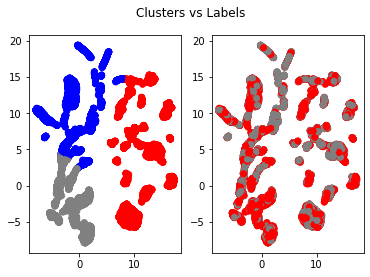

Test data


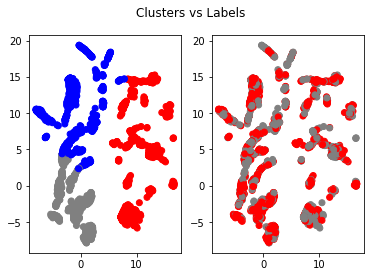

In [307]:
plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train, X_test, y_test)

# No Batch Local Hard Clusters

In [308]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, model.ae) for _ in range(args.n_clusters)]
# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 700
device = 'cpu'
model.eval()


qs, latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
X_latents_data_loader = list(zip(torch.FloatTensor(np.array(X_train)).to(args.device),\
                                 cluster_id_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

qs, latents_test = model(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")
q_test = qs[0]
cluster_id_test = torch.argmax(q_test, axis=1)
# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

X_train = torch.FloatTensor(np.array(X_train)).to(args.device)
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    for k in range(args.n_clusters):
        idx = np.where(cluster_id_train == k)[0]
        y_pred_idx, loss = classifiers[k].fit(X_train[idx], torch.tensor(y_train[idx]).to(device))
        y_pred.append(y_pred_idx)
        new_y.append(y_train[idx])
        epoch_loss += loss
#         print("Cluster: ", k, "F1: ", accuracy_score(np.argmax(y_pred_idx, axis=1), y_train[idx]), "loss: ", loss)
#         print(len(idx), np.argmax(y_pred_idx, axis=1))
#         print(y_pred_idx, y_train[idx])
    y_pred = np.vstack(y_pred)
    new_y = np.hstack(new_y)

    f1 = f1_score(np.argmax(y_pred, axis=1), new_y)
    acc = roc_auc_score(new_y, y_pred[:,1])
    epoch_acc += acc.item()
    epoch_f1 += f1.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    for k in range(args.n_clusters):
        classifiers[k].classifier.eval()
        idx = np.where(cluster_id_test == k)[0]
        latents_idx = latents_test[idx]
#         y_pred_idx = classifiers[k](latents_idx)
        y_pred_idx = classifiers[k](X_test[idx])
        test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test[idx]).to(device))
        test_preds.append(y_pred_idx.detach().numpy())
        new_y_test.append(y_test[idx])

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
    test_acc = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')

Epoch 001: | Train Loss: 0.04392 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.577 | Test Loss: 2.042
Epoch 002: | Train Loss: 0.04365 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.583 | Test Loss: 2.031
Epoch 003: | Train Loss: 0.04345 | Train F1: 0.013 | Train Acc: 0.012| Test F1: 0.642 | Test Acc: 0.587 | Test Loss: 2.023
Epoch 004: | Train Loss: 0.04329 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.590 | Test Loss: 2.017
Epoch 005: | Train Loss: 0.04316 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.591 | Test Loss: 2.012
Epoch 006: | Train Loss: 0.04307 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.593 | Test Loss: 2.008
Epoch 007: | Train Loss: 0.04298 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.597 | Test Loss: 2.004
Epoch 008: | Train Loss: 0.04290 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.642 | Test Acc: 0.601 | Test Loss: 1.999
Epoch 009: | Tra

Epoch 069: | Train Loss: 0.04182 | Train F1: 0.010 | Train Acc: 0.013| Test F1: 0.506 | Test Acc: 0.616 | Test Loss: 1.964
Epoch 070: | Train Loss: 0.04181 | Train F1: 0.010 | Train Acc: 0.013| Test F1: 0.507 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 071: | Train Loss: 0.04180 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.507 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 072: | Train Loss: 0.04179 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.509 | Test Acc: 0.616 | Test Loss: 1.963
Epoch 073: | Train Loss: 0.04178 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.510 | Test Acc: 0.616 | Test Loss: 1.962
Epoch 074: | Train Loss: 0.04177 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.513 | Test Acc: 0.615 | Test Loss: 1.962
Epoch 075: | Train Loss: 0.04176 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.514 | Test Acc: 0.615 | Test Loss: 1.962
Epoch 076: | Train Loss: 0.04175 | Train F1: 0.011 | Train Acc: 0.013| Test F1: 0.514 | Test Acc: 0.616 | Test Loss: 1.961
Epoch 077: | Tra

Epoch 136: | Train Loss: 0.04130 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.597 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 137: | Train Loss: 0.04130 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.591 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 138: | Train Loss: 0.04129 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.588 | Test Acc: 0.620 | Test Loss: 1.949
Epoch 139: | Train Loss: 0.04129 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 140: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 141: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.591 | Test Acc: 0.620 | Test Loss: 1.949
Epoch 142: | Train Loss: 0.04128 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.619 | Test Loss: 1.948
Epoch 143: | Train Loss: 0.04127 | Train F1: 0.013 | Train Acc: 0.013| Test F1: 0.596 | Test Acc: 0.618 | Test Loss: 1.948
Epoch 144: | Tra

Epoch 204: | Train Loss: 0.04103 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.608 | Test Acc: 0.635 | Test Loss: 1.943
Epoch 205: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.603 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 206: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.612 | Test Acc: 0.632 | Test Loss: 1.941
Epoch 207: | Train Loss: 0.04102 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.601 | Test Acc: 0.635 | Test Loss: 1.944
Epoch 208: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.601 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 209: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.614 | Test Acc: 0.632 | Test Loss: 1.941
Epoch 210: | Train Loss: 0.04101 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.604 | Test Acc: 0.634 | Test Loss: 1.944
Epoch 211: | Train Loss: 0.04100 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.608 | Test Acc: 0.635 | Test Loss: 1.944
Epoch 212: | Tra

Epoch 272: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.640 | Test Loss: 1.938
Epoch 273: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 274: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.610 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 275: | Train Loss: 0.04087 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.609 | Test Acc: 0.641 | Test Loss: 1.938
Epoch 276: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.611 | Test Acc: 0.640 | Test Loss: 1.937
Epoch 277: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.609 | Test Acc: 0.641 | Test Loss: 1.939
Epoch 278: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.613 | Test Acc: 0.640 | Test Loss: 1.937
Epoch 279: | Train Loss: 0.04086 | Train F1: 0.013 | Train Acc: 0.014| Test F1: 0.606 | Test Acc: 0.641 | Test Loss: 1.939
Epoch 280: | Tra

KeyboardInterrupt: 

# Embedding Classifier

In [108]:
# Training separate models
args.lr = 0.002
classifiers = [NNClassifier(args, input_dim=args.input_dim) for _ in range(1)]

# optimizers = [torch.optim.Adam(classifiers[i].classifier.parameters(), lr=args.lr) for i in range(args.n_clusters)]
EPOCHS = 1000
device = 'cpu'
model.eval()

latents_X = model.ae(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
X_latents_data_loader = list(zip(latents_X, cluster_id_train, y_train))
train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

latents_test = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), output="latent")

# plot(latents_X, y_train, latents_test, y_test)

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    acc = 0

    new_y = []
    y_pred = []
    y_pred_idx, loss = classifiers[0].fit(latents_X, torch.tensor(y_train).to(device))
    y_pred.append(y_pred_idx)
    new_y.append(y_train)
    epoch_loss += loss
    y_pred = np.vstack(y_pred)
    new_y = np.hstack(new_y)

    acc = f1_score(np.argmax(y_pred, axis=1), new_y)
#     acc = roc_auc_score(new_y, y_pred[:,1])
    epoch_acc += acc.item()

    test_preds = []
    test_loss = 0.0
    new_y_test = []
    classifiers[0].classifier.eval()
    latents_idx = latents_test
    y_pred_idx = classifiers[0](latents_idx)
    test_loss += nn.CrossEntropyLoss(reduction='mean')(y_pred_idx, torch.tensor(y_test).to(device))
    test_preds.append(y_pred_idx.detach().numpy())
    new_y_test.append(y_test)

    test_preds = np.vstack(test_preds)
    new_y_test = np.hstack(new_y_test).reshape(-1)
    test_f1 = f1_score(np.argmax(test_preds, axis=1), new_y_test)
#     test_f1 = roc_auc_score(new_y_test, test_preds[:,1])

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss:.5f} | Train Acc: {epoch_acc:.3f} | Test Acc: {test_f1:.3f} | Test Loss: {test_loss:.3f}')

out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())  

NameError: name 'cluster_id_train' is not defined

# Base Approch

In [18]:
print(X_train.shape)
m = NNClassifier(args, input_dim=args.input_dim)
print(m)
EPOCHS = 100
device = 'cpu'

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    alpha = (1-e/EPOCHS)
    acc = 0
    for X_batch, y_batch, _ in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         latents = model.autoencoder(torch.FloatTensor(np.array(X_batch)).to(args.device), latent=True)
#         cluster_id = model.clustering.update_assign(latents.cpu().detach().numpy())
        y_pred, train_loss = m.fit(X_batch, y_batch)
        epoch_loss += train_loss

        f1 = f1_score(np.argmax(y_pred, axis=1), y_batch.detach().numpy())
        acc = roc_auc_score(y_batch, y_pred[:,1])
        epoch_acc += acc.item()
        epoch_f1 += f1.item()

    test_loss = 0.0

    m.classifier.eval()
    test_pred = m(torch.FloatTensor(np.array(X_test)).to(args.device))
    test_loss += nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.tensor(y_test).to(device))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)
    test_acc = roc_auc_score(y_test, test_pred[:,1].detach().numpy())

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f} | Train Acc: {epoch_acc/len(train_loader):.3f}| Test F1: {test_f1:.3f} | Test Acc: {test_acc:.3f} | Test Loss: {test_loss:.3f}')


torch.Size([8943, 89])
NNClassifier(
  (criterion): CrossEntropyLoss()
  (classifier): Sequential(
    (0): Linear(in_features=89, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [16]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

In [22]:
igs = []
for i in range(args.n_clusters):
    ig = IntegratedGradients(classifiers[i])
    test_input_tensor = X_test
    test_input_tensor.requires_grad_()
    latents_X = model.ae(test_input_tensor, output="latent")
    attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
    attr = attr.detach().numpy()
    igs.append([ig, attr])

Average Feature Importances
SAPS-I :  -0.001
SOFA :  -0.000
Length_of_stay :  0.001
Age :  -0.001
Gender :  0.000
Height :  -0.002
Weight :  -0.001
CCU :  -0.002
CSRU :  0.000
SICU :  -0.001
DiasABP_first :  0.001
GCS_first :  -0.003
Glucose_first :  0.000
HR_first :  0.002
MAP_first :  0.002
NIDiasABP_first :  -0.000
NIMAP_first :  0.000
NISysABP_first :  0.001
RespRate_first :  -0.001
SaO2_first :  0.001
Temp_first :  0.001
DiasABP_last :  0.001
GCS_last :  0.007
Glucose_last :  0.000
HR_last :  0.000
MAP_last :  -0.000
NIDiasABP_last :  0.000
NIMAP_last :  0.003
NISysABP_last :  0.001
RespRate_last :  -0.004
SaO2_last :  0.001
Temp_last :  0.001
DiasABP_lowest :  0.001
GCS_lowest :  0.001
Glucose_lowest :  0.000
HR_lowest :  0.000
MAP_lowest :  -0.001
NIDiasABP_lowest :  0.000
NIMAP_lowest :  0.001
NISysABP_lowest :  0.003
RespRate_lowest :  -0.003
SaO2_lowest :  0.000
Temp_lowest :  0.003
DiasABP_highest :  0.001
GCS_highest :  0.010
Glucose_highest :  0.000
HR_highest :  0.002
MAP

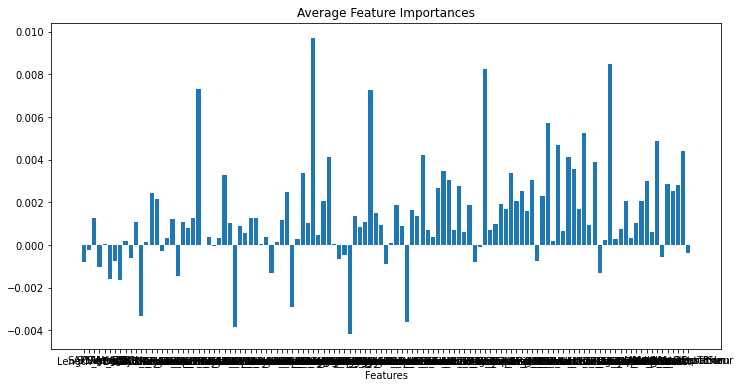

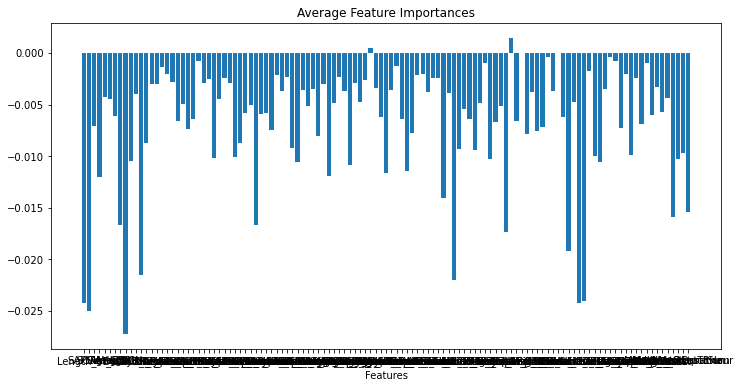

In [23]:
# for k in range(args.n_clusters):
#     idx = np.where(cluster_batch == k)[0]
#     y_pred_idx, loss = classifiers[k].fit(X_batch[idx], y_batch[idx])


for k in range(args.n_clusters):
    classifiers[k].classifier.eval()
    idx = np.where(cluster_id_train == k)[0]
    X_train_idx = torch.FloatTensor(np.array(X_train)).to(args.device)[idx]
    y_pred_idx = classifiers[k](X_train_idx)
    visualize_importances(columns, np.mean(igs[k][1], axis=0))